In [1]:
import os
def get_datasets(path='../UCRArchive_2018'):
    dirs = os.listdir(path)
    return dirs

In [2]:
datasets = get_datasets()
print(datasets)

['Fungi', 'Yoga', 'ECGFiveDays', 'Wine', 'Symbols', 'SemgHandGenderCh2', 'FordB', 'SmallKitchenAppliances', 'SonyAIBORobotSurface2', 'MoteStrain', 'MixedShapesSmallTrain', 'Worms', 'UWaveGestureLibraryY', 'TwoLeadECG', 'GunPointAgeSpan', 'UMD', 'CinCECGTorso', 'PhalangesOutlinesCorrect', 'Adiac', 'DodgerLoopWeekend', 'CBF', 'PigCVP', 'DistalPhalanxTW', 'FaceFour', 'Crop', 'ElectricDevices', 'OliveOil', 'Chinatown', 'GunPointOldVersusYoung', 'HouseTwenty', 'UWaveGestureLibraryAll', 'DodgerLoopDay', 'DodgerLoopGame', 'Car', 'AllGestureWiimoteY', 'HandOutlines', 'BirdChicken', 'WordSynonyms', 'SmoothSubspace', 'SyntheticControl', 'BME', 'UWaveGestureLibraryZ', 'TwoPatterns', 'FordA', 'FiftyWords', 'UWaveGestureLibraryX', 'SemgHandMovementCh2', 'FaceAll', 'FreezerSmallTrain', 'ProximalPhalanxTW', 'PickupGestureWiimoteZ', 'DistalPhalanxOutlineAgeGroup', 'Meat', 'MixedShapesRegularTrain', 'AllGestureWiimoteX', 'FacesUCR', 'InsectEPGRegularTrain', 'NonInvasiveFetalECGThorax1', 'ECG200', 'Beef

In [3]:
dataset = datasets[10]
dataset='OSULeaf'
print(dataset)

OSULeaf


In [4]:
import numpy as np
data = np.load('./datasets/%s.npy' % dataset, allow_pickle=True).item()
value = data['data']

In [5]:
value.shape

(442, 427)

In [6]:
def split_x_y(value, ratio=0.2):
    y_len = int(value.shape[1] * ratio)
    x_len = int(value.shape[1] - y_len)
    return value[:, : x_len], value[:, -y_len: ]

In [7]:
x, y = split_x_y(value, ratio=0.2)

In [8]:
x.shape, y.shape

((442, 342), (442, 85))

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(353, 342) (353, 85) (89, 342) (89, 85)


In [11]:
import statsmodels.api as sm

In [17]:
y_hat = []
ts = pd.date_range('1/1/2000', freq='H', periods=x.shape[-1])
te = pd.date_range('1/1/2000', freq='H', periods=x.shape[-1] + y.shape[-1])
num_samples = x_test.shape[0]
for i in range(num_samples):
    print('\rprocessing... %d/%d' % (i + 1, num_samples), end='')
    xi = x_test[i]
    xi = pd.DataFrame(xi, index=ts, columns=['value'])
    model = sm.tsa.statespace.SARIMAX(xi, order=(2, 0, 1))
    results = model.fit()
    y_hati = results.predict(start=te[x.shape[-1]], end=te[-1], dynamic=True)
    y_hat.append(y_hati)
print(' Done!')
y_hat = np.array(y_hat)

processing... 89/89 Done!


In [18]:
y_hat.shape, y_test.shape

((89, 85), (89, 85))

In [19]:
def normalized_quantile_loss(y_true, y_pred, q=0.5):
    QL = 2.0 * np.sum(
                np.abs(
                    (y_pred - y_true)
                    * ((y_pred >= y_true) - q)
                )
         )
    norm = np.sum(np.abs(y_true))
    if norm > 0:
        return QL / norm
    else:
        return QL / np.sum(np.abs(y_pred))
    return QL / norm

In [20]:
p50 = normalized_quantile_loss(y_test, y_hat, q=0.5).item()
p90 = normalized_quantile_loss(y_test, y_hat, q=0.9).item()
print('p50:%.6f, p90:%.6f' % (p50, p90))

p50:0.846713, p90:0.889312


In [15]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
def diff_analyse(x):
    diff1 = x.diff(1)
    diff2 = diff1.diff(1)
    fig = plt.figure(figsize=(20,6))
    ax1 = fig.add_subplot(131)
    ax1.plot(x)
    ax2 = fig.add_subplot(132)
    ax2.plot(diff1)
    ax3 = fig.add_subplot(133)
    ax3.plot(diff2)
    plt.show()
    
def parameter_evaluate_info_rule(x):
    print('Evaluating parameter AR and MA.\nThis may take a while, be patient...', end='')
    x_results = sm.tsa.arma_order_select_ic(x, ic=['aic', 'bic', 'hqic'], trend='nc', max_ar=3, max_ma=3)
    print('Done!')
    print('AIC', x_results.aic_min_order)
    print('BIC', x_results.bic_min_order)
    print('HQIC', x_results.hqic_min_order)

def ARIMA_identify(x): # identify parameters
    diff_analyse(x)
    parameter_evaluate_info_rule(x)

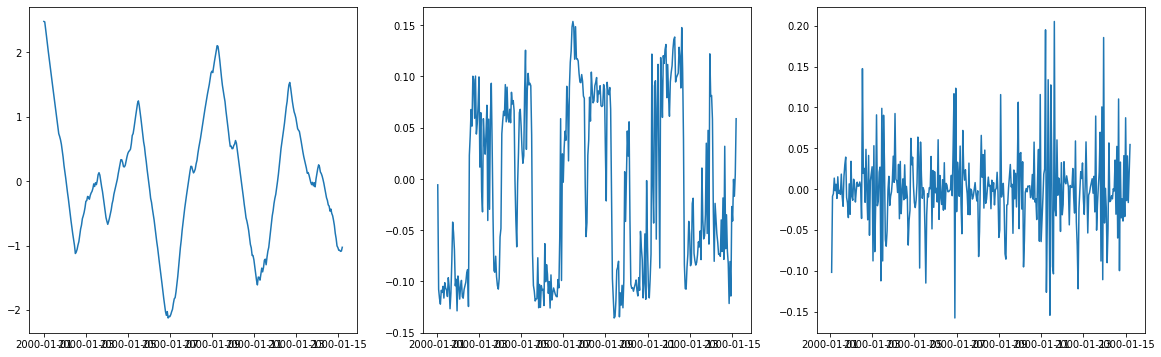

Evaluating parameter AR and MA.
This may take a while, be patient...Done!
AIC (2, 1)
BIC (2, 1)
HQIC (2, 1)


In [16]:
idx = 0
xi = pd.DataFrame(x_test[idx], index=ts, columns=['value'])
ARIMA_identify(xi)